Thermal Convection
======

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**This example introduces:**
1. Setting up material parameters and functions.
2. Setting up and solving systems, Stokes and Advection Diffusion.
3. The time stepping loop.
4. Plotting with glucifer.

**Keywords:** material parameters, Stokes system, advective diffusive systems

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [90]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np


Setup parameters
-----

In [91]:
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set the resolution.
res = 48
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0

Create mesh and variables
------

The mesh object has both a primary and sub mesh. "Q1/dQ0" produces a primary mesh with element type Q1 and a sub-mesh with elements type dQ0. Q1 elements have nodes at the element corners, dQ0 elements have a single node at the elements centre.

In [92]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (2*res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

Create mesh variables.  Note the pressure field uses the sub-mesh. 

In [93]:
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# Initialise values
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

Set up material parameters and functions
-----

Set functions for viscosity, density and buoyancy force. These functions and variables only need to be defined at the beginning of the simulation, not each timestep.

In [94]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [95]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

Set top and bottom wall temperature boundary values.

In [96]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for ``I`` (vertical) and ``J`` (horizontal) walls.

In [97]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions can be found in the **Systems** section of the user guide.

In [98]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the incompressible Stokes equations.  

In [99]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

In [100]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = tempBC )

## Swarm

In [101]:
#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=30)

gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.

tempVariable      = gSwarm.add_variable( dataType="float", count=1 )
tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]

## Marker line

Create a simple marker line

In [102]:
from unsupported_dan.interfaces.marker2D import markerLine2D
from unsupported_dan.faults.faults2D import fault2D, fault_collection

In [103]:
def copy_markerLine2D(ml, thickness=False, ID=False):
    
    """
    
    """
    if not thickness:
        thickness = ml.thickness
    if not ID:
        ID = -1*ml.ID
    new_line = markerLine2D(mesh, velocityField, [], [], thickness,  ID)
    if ml.swarm.particleCoordinates.data.shape[0] > 0:
        new_line.swarm.add_particles_with_coordinates(ml.swarm.particleCoordinates.data[:]) #deep copy
        
    new_line.rebuild()
    return new_line

In [104]:
markerline  = fault2D(mesh, velocityField, [], [], 0.05, 0., 0., 1)
markerline.add_points(np.linspace(0.25, 0.75, 100), np.linspace(0.25, 0.75, 100))


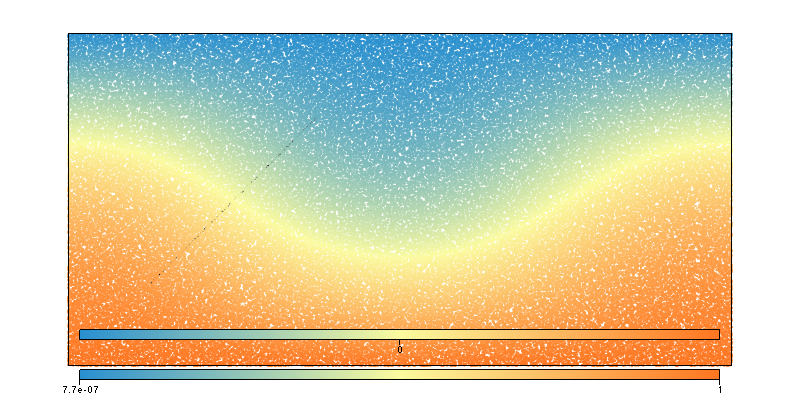

In [105]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Points(gSwarm, tempVariable, pointSize=3) )

figtemp.append( glucifer.objects.Points(markerline.swarm, pointSize=3) )
figtemp.show()

In [113]:
from scipy.spatial import cKDTree as kdTree

def nn_evaluation(fromSwarm, toSwarm, n=1, weighted=False):
    """
    This function provides nearest neighbour information for uw swarms, 
    given the "toSwarm", this function returns the indices of the n nearest neighbours in "fromSwarm"
    it also returns the inverse-distance if weighted=True. 
    
    The function works in parallel.
    
    The arrays come out a bit differently when used in nearest neighbour form
    (n = 1), or IDW: (n > 1). The examples belowe show how to fill out a swarm variable in each case. 
    
    
    Usage n = 1:
    ------------
    ix, weights = nn_evaluation(swarm, fault.swarm, n=n, weighted=False)
    toSwarmVar.data[:][:,0] =  fromSwarmVar.evaluate(fromSwarm)[_ix][:,0]
    
    Usage n > 1:
    ------------
    ix, weights = nn_evaluation(swarm, fault.swarm, n=n, weighted=False)
    toSwarmVar.data[:][:,0] =  np.average(fromSwarmVar.evaluate(fromSwarm)[ix][:,:,0], weights=weights, axis=1)
    
    """
    
    #print("fromSwarm data shape", fromSwarm.particleCoordinates.data.shape)
    
    if len(toSwarm.particleCoordinates.data) > 0: #this is required for safety in parallel
        
        #we rebuild the tree as we assume the 'fromSwarm' is being advected
        fromSwarm.tree = kdTree(fromSwarm.particleCoordinates.data) 
        tree = fromSwarm.tree
        d, ix = tree.query(toSwarm.particleCoordinates.data, n)
        if n == 1:
            weights = np.ones(toSwarm.particleCoordinates.data.shape[0])
        elif not weighted:
            weights = np.ones((toSwarm.particleCoordinates.data.shape[0], n))*(1./n)
        else:
            weights = (1./d[:])/(1./d[:]).sum(axis=1)[:,None]
        return ix,  weights 
    else:
        return  np.empty(0., dtype="int"),  np.empty(0., dtype="int")

Main time stepping loop
-----

In [117]:
#interp = 'nn'
interp = 'idw'

In [118]:
gSwarm.shadow_particles_fetch()

In [122]:
np.average(tempVariable.data[_ix][:,:,0], weights=_weights, axis=1)

array([ 0.79918791,  0.79724123,  0.78980751,  0.78415625,  0.7782031 ,
        0.77227323,  0.7651418 ,  0.76206385,  0.75417852,  0.74605565,
        0.74192399,  0.73320556,  0.72825055,  0.7225021 ,  0.71536052,
        0.70868322,  0.70199156,  0.69639209,  0.6860956 ,  0.68255013,
        0.676789  ,  0.67044096,  0.66157807,  0.65287055,  0.64824419,
        0.64306787,  0.6340844 ,  0.62807879,  0.61926633,  0.61230665,
        0.60413955,  0.59804948,  0.59134823,  0.58462656,  0.57767287,
        0.5694709 ,  0.56556614,  0.55695231,  0.54986845,  0.53970943,
        0.53469262,  0.52631631,  0.51930802,  0.51236688,  0.50631973,
        0.5007965 ,  0.49147779,  0.48549186,  0.47990586,  0.47231065,
        0.46613086,  0.45469311,  0.4507191 ,  0.4424104 ,  0.43862   ,
        0.42902465,  0.42196714,  0.41434148,  0.40977546,  0.401591  ,
        0.39418074,  0.38862092,  0.38200628,  0.37522993,  0.36733084,
        0.36388461,  0.35406814,  0.34948573,  0.34327689,  0.33

In [125]:
# init these guys
time = 0.
step = 0
steps_end = 5

# perform timestepping
while step < steps_end:
    
    #print(testVar.data.max())
    
    #if step > 0:
    #   del newline 
    
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    dt = advDiff.get_max_dt()
    # Advect using this timestep size.
    markerline.advection(dt)
    advDiff.integrate(dt)
    time+=dt
    step+=1
    
    uw.barrier()
    
    if step > 1:
        del testVar, newline 
    #Now lets do a NN intepolation on to the marker line
    markerline.swarm.update_particle_owners()
    newline  = copy_markerLine2D(markerline)
    ds = 0.05
    with newline .swarm.deform_swarm():
        newline .swarm.particleCoordinates.data[...] -= newline .director.data[...]*ds
    
    #newline  = fault2D(mesh, velocityField, [], [], 0.05, 0., 0., 2)
    #newline.add_points(np.linspace(0.25, 0.75, 100) + 1e-3, np.linspace(0.25, 0.75, 100) + 1e-3)
    
        
    testVar = newline.swarm.add_variable( dataType="float", count=1 )
    testVar.data[:] = 0.
    
    if interp == 'nn':
        _ix, _weights = nn_evaluation(gSwarm, newline.swarm, n=1, weighted=False)
        uw.barrier()

        testVar.data[:][:,0] =  tempVariable.evaluate(gSwarm)[_ix][:,0]
        
    if interp == 'idw':
        _ix, _weights = nn_evaluation(gSwarm, newline.swarm, n=40, weighted=False)
        uw.barrier()
        testVar.data[:][:,0] =  np.average(tempVariable.data[_ix][:,:,0], weights=_weights, axis=1)
        

    uw.barrier()
    #print(tempVariable.evaluate(gSwarm)[_ix][:,0])
    
    #del _ix, _weights

    
    


**Plot final temperature and velocity field**


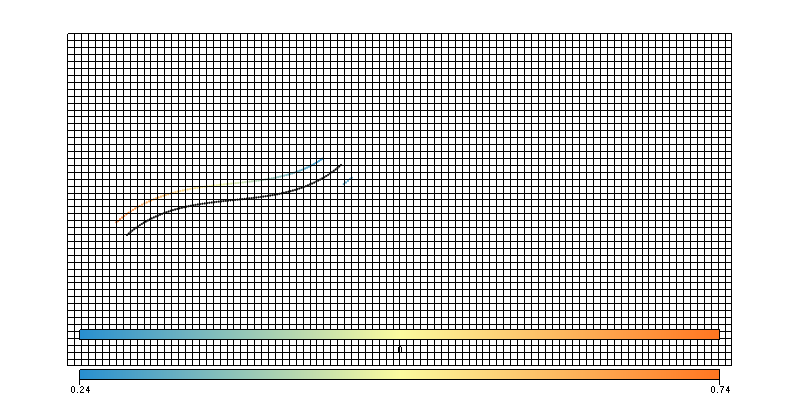

'test.gldb'

In [126]:
newfig = glucifer.Figure( figsize=(800,400) )

newfig.append( glucifer.objects.Points(newline.swarm, testVar,pointSize=3 ) )
newfig.append( glucifer.objects.Points(markerline.swarm,pointSize=3) )
newfig.append(glucifer.objects.Mesh(mesh))

newfig.show()
newfig.save_database('test.gldb')

In [86]:
print(testVar.data)

[[ 0.85077506]
 [ 0.84471911]
 [ 0.83887917]
 [ 0.83604336]
 [ 0.82815385]
 [ 0.82446593]
 [ 0.81684941]
 [ 0.81103134]
 [ 0.80711788]
 [ 0.7993198 ]
 [ 0.79393309]
 [ 0.78845173]
 [ 0.78327447]
 [ 0.77585208]
 [ 0.77056062]
 [ 0.76450539]
 [ 0.75695521]
 [ 0.7501303 ]
 [ 0.74346453]
 [ 0.73701584]
 [ 0.73113644]
 [ 0.72291589]
 [ 0.71487087]
 [ 0.70862383]
 [ 0.70215946]
 [ 0.69611353]
 [ 0.68849361]
 [ 0.67912906]
 [ 0.66917127]
 [ 0.66463912]
 [ 0.65661663]
 [ 0.64749187]
 [ 0.63973689]
 [ 0.63410455]
 [ 0.62655139]
 [ 0.61580932]
 [ 0.61151356]
 [ 0.60160077]
 [ 0.59049028]
 [ 0.58452606]
 [ 0.57671994]
 [ 0.56849116]
 [ 0.56204778]
 [ 0.55181956]
 [ 0.54279888]
 [ 0.53458673]
 [ 0.5273729 ]
 [ 0.51983732]
 [ 0.51084107]
 [ 0.50459677]
 [ 0.49431881]
 [ 0.48847523]
 [ 0.47717974]
 [ 0.47002387]
 [ 0.46544552]
 [ 0.45206878]
 [ 0.44607651]
 [ 0.43771106]
 [ 0.43232802]
 [ 0.42360529]
 [ 0.41138208]
 [ 0.40762958]
 [ 0.39605755]
 [ 0.39013079]
 [ 0.3844094 ]
 [ 0.37287313]
 [ 0.36907